# Ex 9: The Martian

In [138]:
import matplotlib.pyplot as plt
from math import pi

from space_base import GravBody, Probe
from numpy import linspace, sqrt, pi, cos, sin, arccos

# Define constants
G = 6.67e-11  # Gravitational constant
mars = GravBody(name="Mars", mass=0.64169e24, radius=3389.5e3)  # Mars as an object with mass and radius
sun = GravBody(name="Sun", mass=1_988_500e24, radius=695_700e3)  # Sun as an object with mass and radius

# Define conversion function
def UA_to_meters(UA):
    return UA * 1.496e11

The first step is to design a circular orbit at an altitude of 200km. For this, we can use the previous energy formula and simplify it for perfectly circular orbit.

$$a=\frac{r_{perihelion}+r_{aphelion}}{2}$$
$$r_{perihelion}=r_{aphelion}=r=a$$
$$V=\sqrt{GM_{sun}(\frac{2}{r}-\frac{1}{a})}$$
$$V=\sqrt{\frac{GM_{sun}}{r}}$$

In [139]:
r = 200e3 + mars.radius  # Radius distance in meters
v_init = sqrt(G * mars.mass / r)  # Velocity on initial circular orbit
v_init / 1e3  # Velocity at perihelion in km/s

3.4530953751079427

We also need to compute the require velocity the probe need to have at its aphelion to return to earth using an Hohmann transfer. This will be our needed residual velocity. 

In [140]:
r_earth = UA_to_meters(1)  # Earth's radius in meters
r_mars = UA_to_meters(1.524)  # Mars' radius in meters

# Define the probe final orbit
r_per = r_earth  # Perihelion distance
r_aph = r_mars  # Aphelion distance

a_tfr = (r_per + r_aph) / 2  # Semi-major axis
v_hyp_abs = sqrt(G * sun.mass * (2 / r_aph - 1 / a_tfr))  # Absolute velocity at aphelion (relative to the Sun)
v_hyp_abs / 1e3  # Residual velocity in km/s

21.47028240604332

In [141]:
v_mars = sqrt(G * sun.mass / r_mars)  # Mars' velocity
v_hyp = v_hyp_abs - v_mars  # Hypothetical velocity at aphelion (relative to Mars)
v_hyp / 1e3  # Velocity in km/s

-2.6491694858055017

To obtain the velocity at the periapsis of our probe around Mars so that it can escape it we can use the energy formula. We already know that $E=\frac{1}{2}V^2-\frac{GM_{mars}}{r}$, so when $r\rightarrow\infty;E=\frac{1}{2}V_{hyp}^2$

So,

$$\frac{1}{2}V_{hyp}^2=\frac{1}{2}V_{per}^2-\frac{GM_{mars}}{r_{per}}$$
$$2*(\frac{1}{2}V_{hyp}^2+\frac{GM_{mars}}{r_{per}})=V_{per}^2$$
$$V_{per}=\sqrt{V_{hyp}^2+\frac{2GM_{mars}}{r_{per}}}$$

In [142]:
v_per = sqrt(v_hyp**2 + 2*G*mars.mass/r)
v_per / 1e3  # Velocity at perihelion in km/s

5.555702863158424

We can also compute $a$ and $e$ for this escape orbit with:
$$a=\frac{GM_{mars}}{V_{hyp}^2}$$
$$e=\frac{r_p}{a}+1$$

In [143]:
a = G*mars.mass / (v_hyp**2)  # Semi-major axis
a / 1e3  # Semi-major axis in km

6098.620611701382

In [144]:
e = 1 + (r / a)  # Eccentricity
e # Eccentricity

1.5885757171241068

We can also deduce the $\beta$ angle with $\cos{\beta}=\frac{1}{e}$

In [145]:
beta_angle=arccos(1/e)
beta_angle * 180 / pi  # Beta angle in degrees

50.98714749340521

With these settings we will be firing our probe in the opposition direction from Mars orbit as we need to slow down to lower our perihelion to match Earth orbit.

Finally, we can plot the trajectory until the probe reach a point PM which is as far as 18 times the mars radius from the planet center. We can overestimate the time needed for the probe to reach the point by taking as mean velocity the lowest one (v_hyp) and use an event condition to trigger the end of the simulation at the right time.

In [146]:
def probeqns(_, posvel):
    r = sqrt(posvel[0] ** 2 + posvel[1] ** 2)
    f = -G * mars.mass / r ** 3
    gravity_force = f * posvel[0:2]
    axy = gravity_force

    return posvel[2], posvel[3], axy[0], axy[1]

In [147]:
xy0 = [-r*cos(beta_angle), r*sin(beta_angle)]  # start position
vxy0 = [sin(beta_angle)*v_per, cos(beta_angle)*v_per]  # start vertical speed
period = 18*mars.radius / abs(v_hyp)

probe = Probe(probeqns, period, period, x0=xy0[0], vx0=vxy0[0], 
            y0=xy0[1], vy0=vxy0[1], event=mars.radius*18, eventflip=True) # probe as an object
t, posvel = probe.odesolve() # solve the differential equations

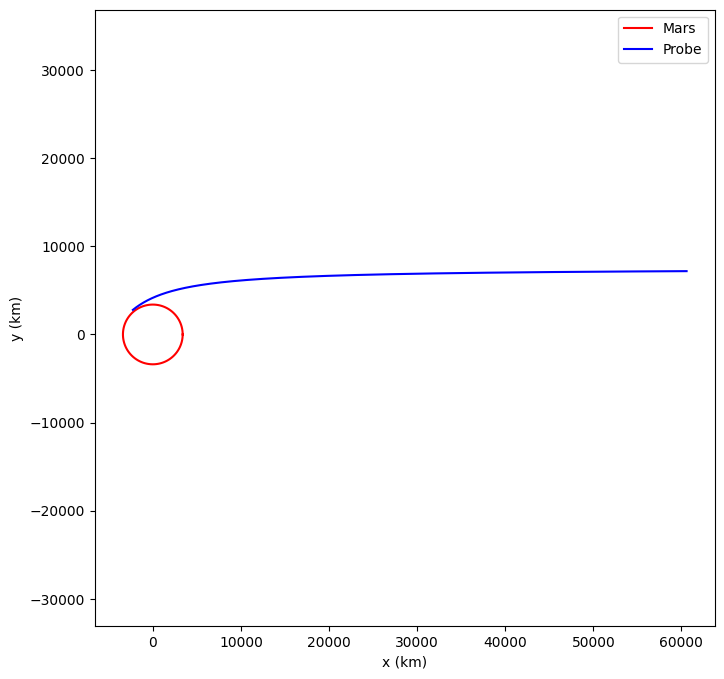

In [148]:
plt.figure(figsize=(8, 8))  # create figure, figsize can be changed as preferred

# Plotting Earth's and Mars' orbit
uang = linspace(0, 2 * pi, 100)
x = (mars.radius / 1e3) * cos(uang)
y = (mars.radius / 1e3) * sin(uang)
plt.plot(x, y, color='red')

plt.plot(posvel[:, 0] / 1e3, posvel[:, 1] / 1e3, color='blue') # plot the probe's orbit

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.axis('equal')
plt.legend(['Mars', 'Probe'])
plt.show() # make plot appear

In [149]:
from datetime import timedelta
str(timedelta(seconds=t[len(t)-1])) # time of flight in hh:mm:ss

'5:17:08.021686'

In [150]:
from numpy.lib.stride_tricks import sliding_window_view
pos_slice = sliding_window_view(posvel[:, 0:2], window_shape = [2, 2])
total_dist = sum([ sqrt((pos[0, 0, 0] - pos[0, 1, 0])**2 +  (pos[0, 0, 1] - pos[0, 1, 1])**2) for pos in pos_slice])

In [151]:
sqrt(posvel[len(t)-1, 0]**2 + posvel[len(t)-1, 1]**2)/ 1e3 # Direct distance from Mars center in km

61011.50753647896

In [152]:
total_dist / 1e3 # Total distance in km

63492.58205912211

In [153]:
(total_dist / t[len(t)-1]) / 1e3 # average speed in km/s

3.3367936564991236